In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
from gymnasium import spaces
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [18]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    df.dropna(inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    
    df['Returns'] = df['Adj_Close'].pct_change()
    df['MA7'] = df['Adj_Close'].rolling(window=7).mean()
    df['MA30'] = df['Adj_Close'].rolling(window=30).mean()
    df['MA7_MA30_Ratio'] = df['MA7'] / df['MA30'].replace(0, np.nan)
    df['MA7_MA30_Ratio'].fillna(1, inplace=True)
    df['Volatility'] = df['Returns'].rolling(window=20).std()
    
    # Calculate RSI
    df['RSI'] = calculate_rsi(df['Adj_Close'], 14)
    df['Volume_Change'] = df['Volume'].pct_change()
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    
    return df

def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    loss = loss.replace(0, np.nan)
    rs = gain / loss
    rs.fillna(0, inplace=True)
    return 100 - (100 / (1 + rs))

# Load data
file_path = r"C:\Users\flyin\OneDrive\Desktop\Crude_Oil_Data.csv"
df = load_and_preprocess_data(file_path)
df.head()


C:\Users\flyin\AppData\Local\Temp\ipykernel_13960\1754542391.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\flyin\AppData\Local\Temp\ipykernel_13960\1754542391.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\flyin\AppData\Local\Temp\ipykernel_13960\1754542391.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value

,Adj_Close,Close,High,Low,Open,Volume,Returns,MA7,MA30,MA7_MA30_Ratio,Volatility,RSI,Volume_Change
Date,,,,,,,,,,,,,
2000-10-04 00:00:00+00:00,31.500000,31.500000,31.900000,31.299999,31.600000,58088,-0.017774,31.411429,33.365333,0.941439,0.035640,40.620502,0.204196
2000-10-05 00:00:00+00:00,30.650000,30.650000,30.950001,30.170000,30.850000,97911,-0.026984,31.290000,33.318667,0.939113,0.035782,29.938289,0.685563
2000-10-06 00:00:00+00:00,30.850000,30.850000,30.959999,30.549999,30.750000,46276,0.006525,31.197143,33.292667,0.937057,0.034627,25.144281,-0.527367
2000-10-09 00:00:00+00:00,31.879999,31.879999,31.920000,31.230000,31.549999,51647,0.033387,31.422857,33.287000,0.943998,0.034109,31.924886,0.116064
2000-10-10 00:00:00+00:00,33.150002,33.150002,33.250000,32.230000,32.250000,78801,0.039837,31.750000,33.296334,0.953558,0.035075,33.333348,0.525761


In [19]:
def prepare_data(df, train_ratio=0.8):
    split_idx = int(len(df) * train_ratio)
    train_data, test_data = df.iloc[:split_idx], df.iloc[split_idx:]
    features = ['Adj_Close', 'Returns', 'MA7', 'MA30', 'MA7_MA30_Ratio', 'Volatility', 'RSI', 'Volume_Change']
    
    scaler = MinMaxScaler()
    train_scaled = pd.DataFrame(scaler.fit_transform(train_data[features]), columns=features, index=train_data.index)
    test_scaled = pd.DataFrame(scaler.transform(test_data[features]), columns=features, index=test_data.index)
    
    return train_scaled, test_scaled, test_data, scaler

train_scaled, test_scaled, test_raw, scaler = prepare_data(df)
train_scaled.head()


,Adj_Close,Returns,MA7,MA30,MA7_MA30_Ratio,Volatility,RSI,Volume_Change
Date,,,,,,,,
2000-10-04 00:00:00+00:00,0.109903,0.407209,0.104925,0.120139,0.426890,0.390094,0.381648,0.000417
2000-10-05 00:00:00+00:00,0.103254,0.379367,0.103938,0.119744,0.421109,0.391986,0.263626,0.000584
2000-10-06 00:00:00+00:00,0.104819,0.480662,0.103184,0.119524,0.415999,0.376585,0.210660,0.000164
2000-10-09 00:00:00+00:00,0.112875,0.561862,0.105018,0.119476,0.433250,0.369671,0.285575,0.000386
2000-10-10 00:00:00+00:00,0.122810,0.581358,0.107676,0.119555,0.457012,0.382559,0.301136,0.000528


In [20]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length]['Adj_Close'])
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(train_scaled, seq_length)
X_train.shape, y_train.shape


((4799, 30, 8), (4799,))

In [21]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

lstm_model = build_lstm_model((seq_length, X_train.shape[2]))

# Thêm early stopping và model checkpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_lstm_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Huấn luyện với callbacks
lstm_model.fit(
    X_train, y_train, 
    epochs=500,  # Tăng số epochs vì có early stopping
    batch_size=32, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/500


C:\Users\flyin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


118/120 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0210
Epoch 1: val_loss improved from inf to 0.00038, saving model to best_lstm_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0207 - val_loss: 3.7640e-04
Epoch 2/500
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0022
Epoch 2: val_loss did not improve from 0.00038
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0022 - val_loss: 4.7862e-04
Epoch 3/500
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018
Epoch 3: val_loss did not improve from 0.00038
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0018 - val_loss: 4.8578e-04
Epoch 4/500
118/120 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
Epoch 4: val_loss did not improve from 0.00038
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0018 - val_loss: 4.5925e-04
Epoch 5/500
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
Epoch 5: val_loss improved from 0.00038 to 0.00027, saving model to best_lstm_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 3

In [22]:
class CrudeOilTradingEnv(gym.Env):
    def __init__(self, df, raw_data=None, initial_capital=100000, transaction_fee_percent=0.001):
        super().__init__()
        self.df = df
        self.raw_data = raw_data
        self.initial_capital = initial_capital
        self.transaction_fee_percent = transaction_fee_percent
        self.action_space = spaces.Discrete(3)  # Buy, Hold, Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(df.shape[1],), dtype=np.float32)
        self.reset()
    
    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.cash = self.initial_capital
        self.shares_held = 0
        self.current_value = self.initial_capital
        self.portfolio_values = [self.initial_capital]  # Track portfolio values
        self.actions_taken = []  # Track actions
        self.transaction_dates = []  # Track dates
        
        # Store current price for visualization
        if self.raw_data is not None:
            self.price_history = [self.raw_data['Adj_Close'].iloc[self.current_step]]
            self.transaction_dates.append(self.raw_data.index[self.current_step])
        
        return self._get_observation(), {}

    def _get_observation(self):
        return self.df.iloc[self.current_step].values

    # Sửa phương thức step trong CrudeOilTradingEnv
    def step(self, action):
        # Lưu thông tin trước khi thực hiện hành động
        current_price = self.raw_data['Adj_Close'].iloc[self.current_step]
        
        # Execute trading action
        reward = 0
        
        if action == 0:  # Buy
            max_shares_to_buy = self.cash // current_price
            if max_shares_to_buy > 0:
                shares_to_buy = max_shares_to_buy  # Buy maximum possible
                cost = shares_to_buy * current_price
                transaction_fee = cost * self.transaction_fee_percent
                total_cost = cost + transaction_fee
                
                self.cash -= total_cost
                self.shares_held += shares_to_buy
                self.actions_taken.append('Buy')
            else:
                self.actions_taken.append('Hold')  # Not enough cash to buy
                
        elif action == 1:  # Hold
            self.actions_taken.append('Hold')
            
        elif action == 2:  # Sell
            if self.shares_held > 0:
                value = self.shares_held * current_price
                transaction_fee = value * self.transaction_fee_percent
                self.cash += value - transaction_fee
                self.shares_held = 0
                self.actions_taken.append('Sell')
            else:
                self.actions_taken.append('Hold')  # No shares to sell
        
        # Calculate portfolio value
        self.current_value = self.cash + (self.shares_held * current_price)
        self.portfolio_values.append(self.current_value)
        
        # Update price history and dates
        if self.raw_data is not None:
            self.price_history.append(current_price)
            self.transaction_dates.append(self.raw_data.index[self.current_step])
        
        # Move to next step
        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        
        # Calculate reward (change in portfolio value)
        if len(self.portfolio_values) >= 2:
            reward = (self.portfolio_values[-1] - self.portfolio_values[-2]) / self.portfolio_values[-2]
        
        return self._get_observation(), reward, terminated, False, {}

In [23]:
def train_rl_model(env, total_timesteps=20000):
    model = PPO('MlpPolicy', env, verbose=1, learning_rate=0.0001)
    model.learn(total_timesteps=total_timesteps)
    return model

env = DummyVecEnv([lambda: CrudeOilTradingEnv(test_scaled.fillna(0), test_raw, initial_capital=100000)])
rl_model = train_rl_model(env)
rl_model.save("crude_oil_trading_model")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1853 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1313        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005545908 |
|    clip_fraction        | 0.000488    |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | -0.0335     |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0104     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0021     |
|    value_loss           | 0.0099      |
-----------------------------------------
-----------------

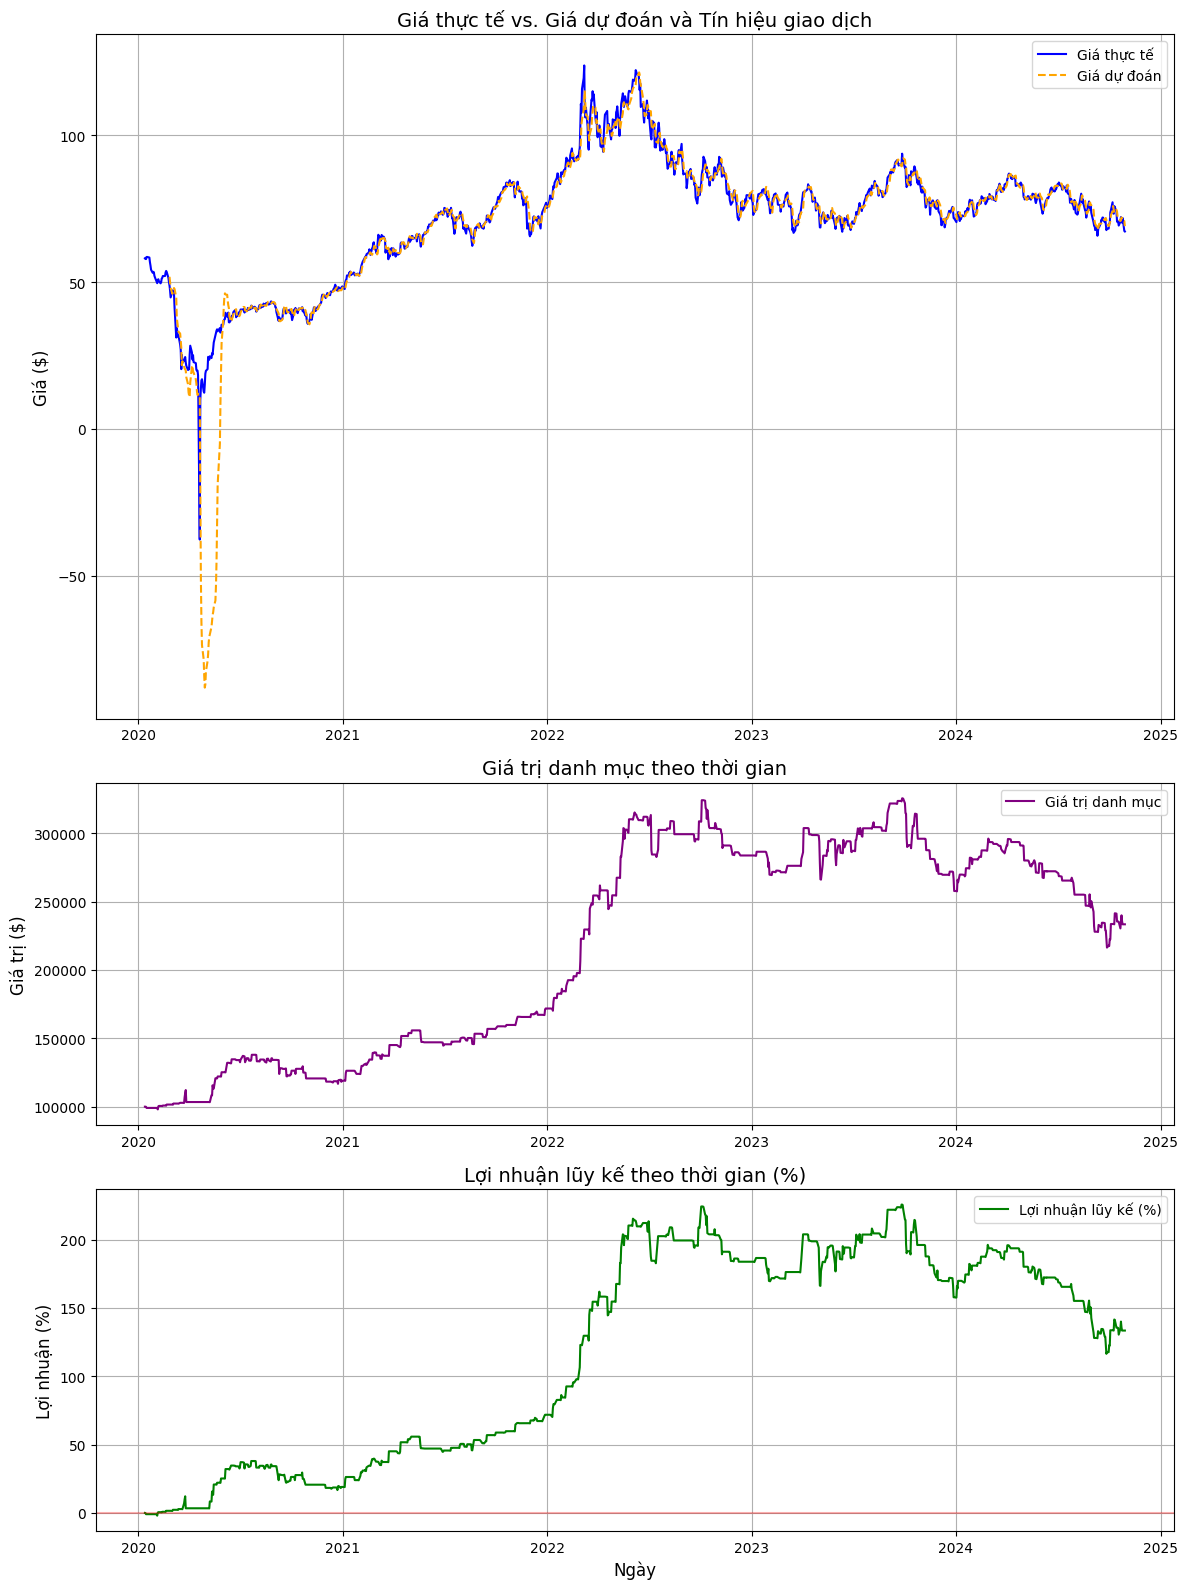

Thống kê hiệu suất giao dịch:
Lợi nhuận cuối cùng: 133.42%
Mức sụt giảm tối đa: -33.54%
Số lần giao dịch: 0

Tổng kết chiến lược giao dịch:
Lợi nhuận cuối cùng: 133.42%
Số lần giao dịch: 0


In [24]:
def evaluate_model_with_trading(model, env, test_df, test_scaled, seq_length, lstm_model, scaler):
    # Thiết lập các biến theo dõi
    observations = []
    actions = []
    portfolio_values = []
    cash_history = []
    shares_history = []
    transaction_dates = []
    transaction_types = []
    transaction_prices = []
    cumulative_returns = []
    
    # Reset environment
    obs, _ = env.reset()
    done = False
    env.cash = env.initial_capital
    env.shares_held = 0
    current_portfolio_value = env.initial_capital
    portfolio_values.append(current_portfolio_value)
    cash_history.append(env.cash)
    shares_history.append(env.shares_held)
    
    # Tạo dự đoán LSTM cho toàn bộ tập dữ liệu thử nghiệm
    lstm_predictions = []
    for i in range(len(test_scaled) - seq_length):
        seq = test_scaled.iloc[i:i+seq_length].values.reshape(1, seq_length, test_scaled.shape[1])
        prediction = lstm_model.predict(seq, verbose=0)[0][0]
        lstm_predictions.append(prediction)
    
    # Thêm giá trị NaN cho các bước đầu tiên không có dự đoán
    lstm_predictions = [np.nan] * seq_length + lstm_predictions
    
    # Mở rộng giá trị dự đoán để khớp với kích thước test_df
    while len(lstm_predictions) < len(test_df):
        lstm_predictions.append(np.nan)
    
    # Chuyển dự đoán về khoảng giá gốc
    predicted_prices = []
    for i, pred in enumerate(lstm_predictions):
        if np.isnan(pred):
            predicted_prices.append(np.nan)
        else:
            # Tạo mảng giả lập với giá trị dự đoán tại vị trí Adj_Close
            dummy = np.zeros((1, test_scaled.shape[1]))
            dummy[0, 0] = pred  # Vị trí 0 là Adj_Close
            # Inverse transform để có giá dự đoán
            inverse_pred = scaler.inverse_transform(dummy)[0, 0]
            predicted_prices.append(inverse_pred)
    
    # Thực hiện giao dịch dựa trên mô hình RL
    step = 0
    initial_value = env.initial_capital
    
    while not done and step < len(test_df) - 1:
        # Lưu trạng thái hiện tại
        observations.append(obs)
        
        # Dự đoán hành động bằng mô hình RL
        action, _states = model.predict(obs)
        actions.append(action)
        
        # Thực hiện hành động và lấy trạng thái mới
        obs, reward, done, _, info = env.step(action)
        
        # Cập nhật portfolio dựa trên hành động
        current_price = test_df.iloc[env.current_step - 1]["Adj_Close"]
        prev_portfolio_value = current_portfolio_value
        
        # Xử lý các hành động (0: Mua, 1: Giữ, 2: Bán)
        if action == 0:  # Mua
            if env.cash > 0:
                # Mua cổ phiếu với toàn bộ số tiền mặt hiện có
                shares_to_buy = int(env.cash / (current_price * (1 + env.transaction_fee_percent)))
                if shares_to_buy > 0:
                    cost = shares_to_buy * current_price * (1 + env.transaction_fee_percent)
                    env.cash -= cost
                    env.shares_held += shares_to_buy
                    transaction_dates.append(test_df.index[env.current_step - 1])
                    transaction_types.append('Mua')
                    transaction_prices.append(current_price)
        
        elif action == 2:  # Bán
            if env.shares_held > 0:
                # Bán toàn bộ cổ phiếu hiện có
                sell_value = env.shares_held * current_price * (1 - env.transaction_fee_percent)
                env.cash += sell_value
                env.shares_held = 0
                transaction_dates.append(test_df.index[env.current_step - 1])
                transaction_types.append('Bán')
                transaction_prices.append(current_price)
        
        # Cập nhật giá trị danh mục đầu tư
        current_portfolio_value = env.cash + env.shares_held * current_price
        portfolio_values.append(current_portfolio_value)
        cash_history.append(env.cash)
        shares_history.append(env.shares_held)
        
        # Tính lợi nhuận lũy kế
        cumulative_return = (current_portfolio_value / initial_value - 1) * 100
        cumulative_returns.append(cumulative_return)
        
        step += 1
    
    # Tạo DataFrame để lưu kết quả
    result_df = pd.DataFrame({
        'Date': test_df.index[:-1],  # Loại bỏ ngày cuối cùng vì không có giao dịch
        'Adj_Close': test_df['Adj_Close'].values[:-1],
        'Predicted_Price': predicted_prices[:-1],
        'Portfolio_Value': portfolio_values[:-1],
        'Cash': cash_history[:-1],
        'Shares': shares_history[:-1],
        'Cumulative_Return': cumulative_returns
    })
    
    # Tạo DataFrame cho các giao dịch
    if transaction_dates:
        transactions_df = pd.DataFrame({
            'Date': transaction_dates,
            'Type': transaction_types,
            'Price': transaction_prices
        })
    else:
        transactions_df = pd.DataFrame(columns=['Date', 'Type', 'Price'])
    
    # Trực quan hóa kết quả
    visualize_trading_results(result_df, transactions_df)
    
    return result_df, transactions_df, cumulative_returns[-1]

def visualize_trading_results(result_df, transactions_df):
    # Tạo figure với 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [2, 1, 1]})
    
    # 1. Biểu đồ giá và dự đoán
    ax1.plot(result_df['Date'], result_df['Adj_Close'], label='Giá thực tế', color='blue')
    ax1.plot(result_df['Date'], result_df['Predicted_Price'], label='Giá dự đoán', color='orange', linestyle='--')
    
    # Đánh dấu các điểm giao dịch
    buy_points = transactions_df[transactions_df['Type'] == 'Mua']
    sell_points = transactions_df[transactions_df['Type'] == 'Bán']
    
    if not buy_points.empty:
        ax1.scatter(buy_points['Date'], buy_points['Price'], color='green', marker='^', s=100, label='Mua')
    
    if not sell_points.empty:
        ax1.scatter(sell_points['Date'], sell_points['Price'], color='red', marker='v', s=100, label='Bán')
    
    ax1.set_title('Giá thực tế vs. Giá dự đoán và Tín hiệu giao dịch', fontsize=14)
    ax1.set_ylabel('Giá ($)', fontsize=12)
    ax1.legend()
    ax1.grid(True)
    
    # 2. Biểu đồ giá trị danh mục đầu tư
    ax2.plot(result_df['Date'], result_df['Portfolio_Value'], label='Giá trị danh mục', color='purple')
    ax2.set_title('Giá trị danh mục theo thời gian', fontsize=14)
    ax2.set_ylabel('Giá trị ($)', fontsize=12)
    ax2.legend()
    ax2.grid(True)
    
    # 3. Biểu đồ lợi nhuận lũy kế
    ax3.plot(result_df['Date'], result_df['Cumulative_Return'], label='Lợi nhuận lũy kế (%)', color='green')
    ax3.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    ax3.set_title('Lợi nhuận lũy kế theo thời gian (%)', fontsize=14)
    ax3.set_xlabel('Ngày', fontsize=12)
    ax3.set_ylabel('Lợi nhuận (%)', fontsize=12)
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Hiển thị thống kê tóm tắt
    final_return = result_df['Cumulative_Return'].iloc[-1]
    max_drawdown = calculate_max_drawdown(result_df['Portfolio_Value'])
    
    print(f"Thống kê hiệu suất giao dịch:")
    print(f"Lợi nhuận cuối cùng: {final_return:.2f}%")
    print(f"Mức sụt giảm tối đa: {max_drawdown:.2f}%")
    print(f"Số lần giao dịch: {len(transactions_df)}")
    if len(transactions_df) > 0:
        print(f"Số lần mua: {len(transactions_df[transactions_df['Type'] == 'Mua'])}")
        print(f"Số lần bán: {len(transactions_df[transactions_df['Type'] == 'Bán'])}")

def calculate_max_drawdown(portfolio_values):
    # Tính toán mức sụt giảm tối đa
    running_max = pd.Series(portfolio_values).cummax()
    drawdown = (portfolio_values - running_max) / running_max * 100
    return drawdown.min()

# Cập nhật class CrudeOilTradingEnv để xử lý giao dịch thực tế
class EnhancedCrudeOilTradingEnv(gym.Env):
    def __init__(self, df, raw_data=None, initial_capital=100000, transaction_fee_percent=0.001):
        super().__init__()
        self.df = df
        self.raw_data = raw_data if raw_data is not None else df
        self.initial_capital = initial_capital
        self.transaction_fee_percent = transaction_fee_percent
        self.action_space = spaces.Discrete(3)  # Buy, Hold, Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(df.shape[1],), dtype=np.float32)
        self.reset()
    
    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.cash = self.initial_capital
        self.shares_held = 0
        self.total_profit = 0
        self.transaction_history = []
        return self._get_observation(), {}

    def _get_observation(self):
        return self.df.iloc[self.current_step].values

    def step(self, action):
        # Lưu trạng thái trước khi thực hiện hành động
        current_price = self.raw_data.iloc[self.current_step]['Adj_Close']
        current_portfolio_value = self.cash + self.shares_held * current_price
        
        # Xử lý hành động: 0 (Mua), 1 (Giữ), 2 (Bán)
        reward = 0
        if action == 0:  # Mua
            if self.cash > 0:
                # Tính số cổ phiếu có thể mua với chi phí giao dịch
                max_shares = int(self.cash / (current_price * (1 + self.transaction_fee_percent)))
                if max_shares > 0:
                    # Mua với 100% số tiền có thể
                    shares_to_buy = max_shares
                    transaction_cost = shares_to_buy * current_price * (1 + self.transaction_fee_percent)
                    self.cash -= transaction_cost
                    self.shares_held += shares_to_buy
                    self.transaction_history.append({
                        'step': self.current_step,
                        'action': 'BUY',
                        'price': current_price,
                        'shares': shares_to_buy,
                        'value': transaction_cost
                    })
        
        elif action == 2:  # Bán
            if self.shares_held > 0:
                # Bán tất cả cổ phiếu hiện có
                sell_value = self.shares_held * current_price * (1 - self.transaction_fee_percent)
                self.cash += sell_value
                self.transaction_history.append({
                    'step': self.current_step,
                    'action': 'SELL',
                    'price': current_price,
                    'shares': self.shares_held,
                    'value': sell_value
                })
                self.shares_held = 0
        
        # Di chuyển đến bước tiếp theo
        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        
        # Tính giá trị danh mục hiện tại nếu chưa kết thúc
        if not terminated:
            next_price = self.raw_data.iloc[self.current_step]['Adj_Close']
            new_portfolio_value = self.cash + self.shares_held * next_price
            # Tính phần thưởng là % thay đổi giá trị danh mục
            reward = (new_portfolio_value - current_portfolio_value) / current_portfolio_value
        
        return self._get_observation(), reward, terminated, False, {}

# Thêm vào phần evaluate_and_visualize
def updated_evaluate_and_visualize():
    # Tạo môi trường giao dịch nâng cao
    enhanced_env = EnhancedCrudeOilTradingEnv(test_scaled.fillna(0), test_raw)
    
    # Tạo env vector
    env = DummyVecEnv([lambda: enhanced_env])
    
    # Tải mô hình RL đã huấn luyện
    loaded_model = PPO.load("crude_oil_trading_model")
    
    # Đánh giá mô hình với chiến lược giao dịch
    results_df, transactions_df, final_return = evaluate_model_with_trading(
        loaded_model, enhanced_env, test_raw, test_scaled, seq_length, lstm_model, scaler
    )
    
    print(f"\nTổng kết chiến lược giao dịch:")
    print(f"Lợi nhuận cuối cùng: {final_return:.2f}%")
    print(f"Số lần giao dịch: {len(transactions_df)}")
    
    return results_df, transactions_df

# Gọi hàm để thực hiện đánh giá và hiển thị kết quả
results_df, transactions_df = updated_evaluate_and_visualize()